# Figure 8: Synthetic multiproxy inference
This notebook can be used to: 
- Load and plot the synthetic d13C, d18O, d34S, and age constraint data (as in Fig. b)
- Build and sample the inference model
- Load the inference results for each experiment (models that include every permutation of the d13C, d18O, and d34S data)
- Calculate the relative likelihood of each model 
- Reproduce Fig. 8 using these data

In [1]:
%load_ext autoreload
%autoreload 2

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import stratmc

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Avenir']
rcParams.update({
    "text.usetex": False
})

from scipy.ndimage import gaussian_filter as gaussian
from scipy.stats import gaussian_kde

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Synthetic proxy signals and data (Fig. 8a-b)

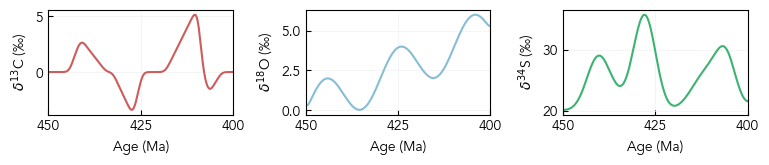

In [2]:
age_vector = np.arange(400, 450, 0.25)
amplitude = [3, -4, 6, -2]

d13c_signal = stratmc.synthetics.make_excursion(age_vector, amplitude, excursion_duration = [10, 8, 10, 5], rising_time = [0.3, 0.7, 0.9, 0.3], 
                               smooth = True, smoothing_factor = 2, rate_offset = True, seed = 7) 
d13c_signal = gaussian(np.flip(d13c_signal), 3)

cyclic_d18o = 1.5 * np.sin((age_vector) * 2 * np.pi * (1/20)) 
long_term_increase = 5
d18o_signal = (cyclic_d18o + long_term_increase / (age_vector[-1] - age_vector[0]) * (age_vector - 400))
d18o_signal = gaussian(np.flip(d18o_signal), 3)

amplitude = [15, 30, 10, 25]
d34s_signal = stratmc.synthetics.make_excursion(age_vector, amplitude, baseline = 20, excursion_duration = [10, 8, 10, 5], rising_time = [0.3, 0.7, 0.9, 0.3], 
                               smooth = True, smoothing_factor = 2, rate_offset = True, seed = 7)
d34s_signal = gaussian(np.flip(d34s_signal), 10)

signal_dict = {}
signal_dict['d13c'] = d13c_signal 
signal_dict['d18o'] = d18o_signal 
signal_dict['d34s'] = d34s_signal 

fs = 10

fig, ax = plt.subplots(1, 3, figsize = (8, 1.75), sharex = True)

ax[0].plot(age_vector, signal_dict['d13c'], color = 'indianred', lw = 1.5) 
ax[0].set_ylabel('$\delta^{13}$C (‰)', fontsize = fs)


ax[1].plot(age_vector, signal_dict['d18o'], color = '#87BED5', lw = 1.5) 
ax[1].set_ylabel('$\delta^{18}$O (‰)', fontsize = fs)

ax[2].plot(age_vector, signal_dict['d34s'], color = 'mediumseagreen', lw = 1.5) 
ax[2].set_ylabel('$\delta^{34}$S (‰)', fontsize = fs)


for axis in ax.ravel():
    axis.grid(color=(0.95, 0.95, 0.95), linewidth=0.5, linestyle = 'solid', zorder = -1)
    axis.set_axisbelow(True)
    axis.tick_params(direction = 'in', labelsize = fs)
    axis.set_xlabel('Age (Ma)', fontsize = fs)

    
ax[0].set_xlim([450, 400])

for axis in ax.ravel():
    axis.set_xticks([450, 425, 400])

fig.tight_layout()


In [3]:
# Load the synthetic proxy observations
sample_df = stratmc.data.load_object('data/Fig8_synthetic_sample_df_multiproxy_modified')
ages_df = stratmc.data.load_object('data/Fig8_synthetic_ages_df_multiproxy_modified')

proxies = ['d13c', 'd18o', 'd34s']

sections = np.unique(sample_df['section'].values)

In [4]:
# define lithostratigraphy
facies_colors = {}
facies_widths = {} 

facies_colors['limestone'] ='#F4F2F3'
facies_colors['diamictite'] = 'gray'

facies_widths['limestone'] = 0.75
facies_widths['diamictite'] = 1

section_facies = {}
section_facies_thicknesses = {}
# section 1
section_facies['1'] = ['limestone']
section_facies_thicknesses['1'] = [np.max(ages_df[ages_df['section']=='1']['height'])]


# section 2
section_facies['2'] = ['limestone']
section_facies_thicknesses['2'] = [np.max(ages_df[ages_df['section']=='2']['height'])]

# section 3
section_facies['3'] = ['limestone']
section_facies_thicknesses['3'] = [np.max(ages_df[ages_df['section']=='3']['height'])]

# section 4
section_facies['4'] = ['limestone']
section_facies_thicknesses['4'] = [np.max(ages_df[ages_df['section']=='4']['height'])]

# section 5
section_facies['5'] = ['limestone']
section_facies_thicknesses['5'] = [np.max(ages_df[ages_df['section']=='5']['height'])]

# section 6
section_facies['6'] = ['limestone']
section_facies_thicknesses['6'] = [np.max(ages_df[ages_df['section']=='6']['height'])]
                       

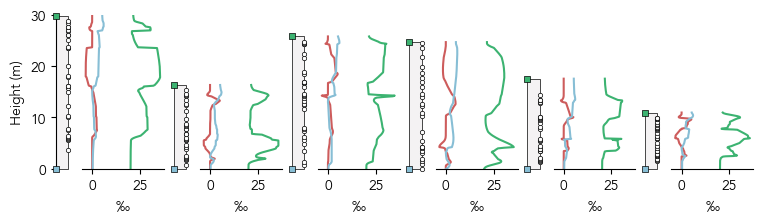

In [5]:
# map the proxy signals back to height in each section (Fig. 8b) 

fs = 10

sample_df, ages_df = stratmc.data.clean_data(sample_df, ages_df, proxies, sections) 

d13c_sections = np.unique(sample_df['section'][~np.isnan(sample_df['d13c'])])

widths = [0.2, 1] * 6

fig, ax = plt.subplots(1, 2 * 6, figsize = (9, 2), sharey = True, sharex = False,  gridspec_kw={'width_ratios': widths})

for i in np.arange(len(d13c_sections)): 
    section = d13c_sections[i]
    
    section_ages_df = ages_df[(ages_df['section'] == section) & (~np.isnan(ages_df['age'])) & (~ages_df['intermediate detrital?'])]
    section_df = sample_df[sample_df['section'] == section]

    sec_sample_ages = sample_df[sample_df['section'] == section]['age'].values
    sec_sample_heights = sample_df[sample_df['section'] == section]['height'].values
    
    sec_radio_ages = section_ages_df['age'].values
    sec_ages_comb = np.concatenate([sec_radio_ages, section_df['age']])
    
    heights_comb = np.concatenate([section_ages_df['height'], section_df['height']])
    
    heights_comb_sort_idx = np.argsort(heights_comb)
    
    sec_ages_comb = sec_ages_comb[heights_comb_sort_idx]
    heights_comb = heights_comb[heights_comb_sort_idx]

    new_heights = np.linspace(np.min(heights_comb), np.max(heights_comb), 200)
    sec_age_interp = np.interp(new_heights, heights_comb, sec_ages_comb)
    
    d13c_section_interp = np.interp(sec_age_interp, age_vector, d13c_signal)
    d18o_section_interp = np.interp(sec_age_interp, age_vector, d18o_signal)
    d34s_section_interp = np.interp(sec_age_interp, age_vector, d34s_signal)

    
    ax[i * 2 + 1].plot(d13c_section_interp, new_heights, c =  'indianred', zorder = 0)
    ax[i * 2 + 1].plot(d18o_section_interp, new_heights, c =  '#87BED5', zorder = 0)
    ax[i * 2 + 1].plot(d34s_section_interp, new_heights, c =  'mediumseagreen', zorder = 0)


    ax[i * 2].scatter(np.ones(len(sample_df[sample_df['section']==section]['d13c'])) * 0.75, sample_df[sample_df['section']==section]['height'], 
                          color = 'white',
                          edgecolor = 'k',
                          marker = 'o',
                          #edgecolor = 'k', 
                          s = 10, 
                          lw = 0.5, 
                          clip_on = False, zorder = 10)
    

    section_ages_df = ages_df[ages_df['section']==section]
    
    for j in np.arange(section_ages_df.shape[0]):
        if j == 0:  # base of sections 
            age_color = '#87BED5'
        
        if j == section_ages_df.shape[0] - 1: # top of sections
            age_color = 'mediumseagreen'
            
        if section_ages_df.iloc[j]['intermediate detrital?']:
            ax[i * 2].scatter(0, section_ages_df.iloc[j]['height'], color = age_color, marker = '^', edgecolor = 'k', s = 30,  lw = 0.5, zorder = 10, clip_on = False)

        else: 
            ax[i * 2].scatter(0, section_ages_df.iloc[j]['height'], color = age_color, edgecolor = 'k', marker = 's', s = 25,  lw = 0.5, zorder = 10, clip_on = False)

        ax[i * 2].set_xlim([0, 1])

    current_base = 0
    for facies, thickness in zip(section_facies[section], section_facies_thicknesses[section]): 
        ax[i * 2].barh(y = current_base,
                    width=facies_widths[facies],
                    height=thickness,
                    linewidth = 0.5,
                    edgecolor='k',
                    align='edge',
                    color=facies_colors[facies], clip_on = False)
        current_base += thickness

    ax[i * 2].set_yticklabels([])
        
    
_ = [ax[i].sharex(ax[1]) for i in [3, 5, 7, 9, 11]]#[3, 5, 7, 9, 11]] # [4, 6, 8, 10, 12]
_ = [ax[i].sharey(ax[0]) for i in np.arange(1, 12)]

    
ax[1].set_ylim([0, np.max(ages_df['height'])])


for i in [0, 2, 4, 6, 8, 10]:
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['bottom'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    ax[i].set_xlim([0, 1])
    ax[i].set_xticks([])
    
for i in [1, 3, 5, 7, 9, 11]:# [2, 4, 6, 8, 10, 12]:
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['bottom'].set_visible(True)
    ax[i].spines['left'].set_visible(False)
    ax[i].set_xlabel('‰', fontsize = fs) 


for axis in ax.ravel():
    axis.set_axisbelow(True)
    axis.set_yticks([])
    axis.tick_params(labelsize = fs)
    
ax[0].spines['left'].set_visible(True)
ax[0].set_ylabel('Height (m)', fontsize = fs) 

ax[0].set_yticks([0, 10, 20, 30]) 
ax[0].set_yticklabels([0, 10, 20, 30]) 

for i in np.arange(1, 12): 
    [t.set_color('none') for t in ax[i].yaxis.get_ticklabels()]
    ax[i].tick_params(axis = 'y', color = 'none')


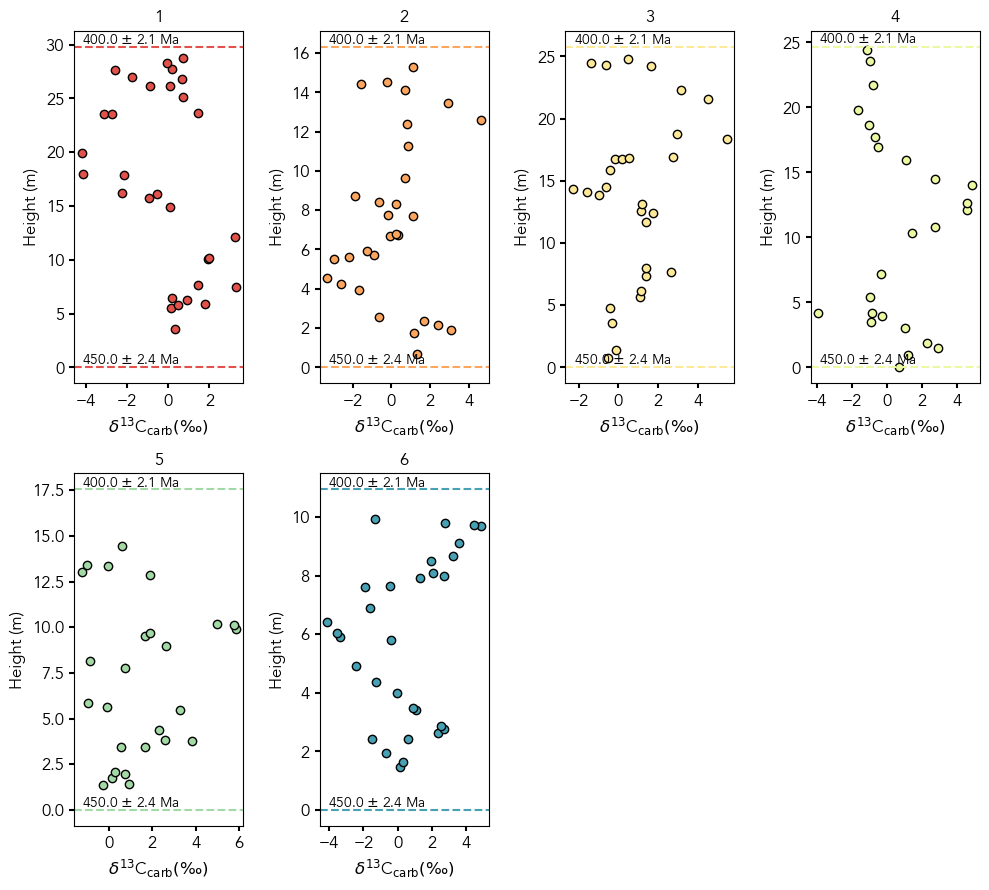

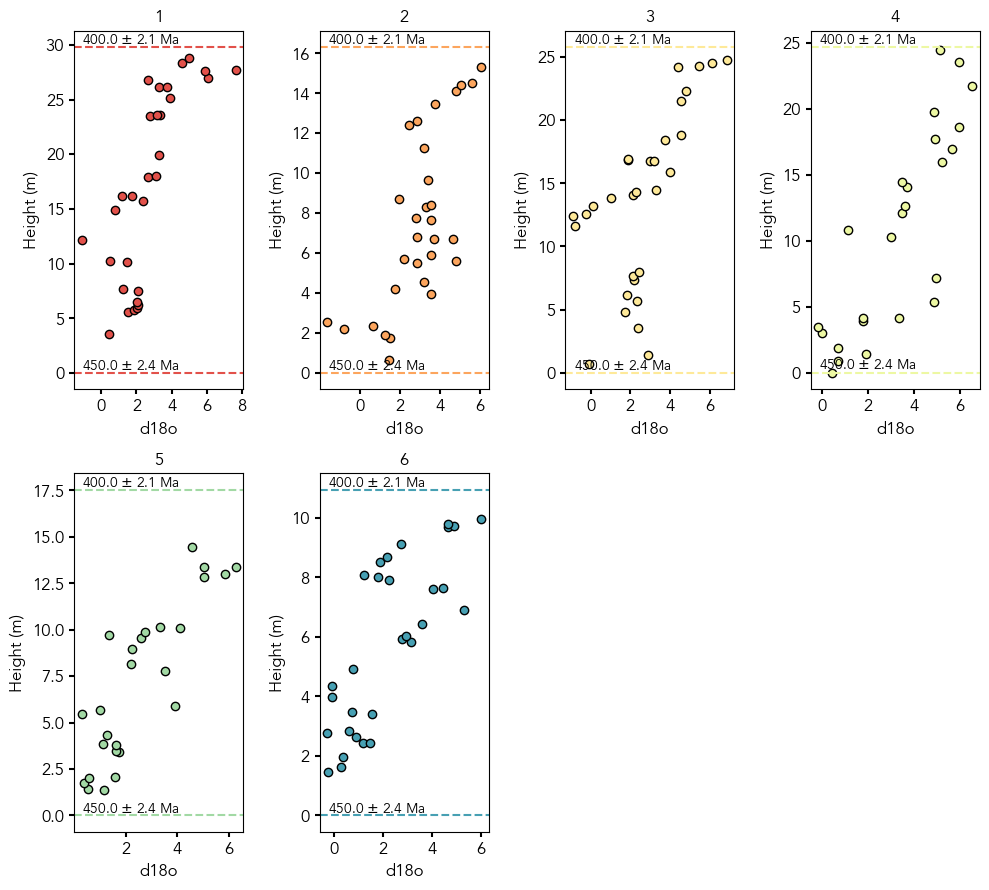

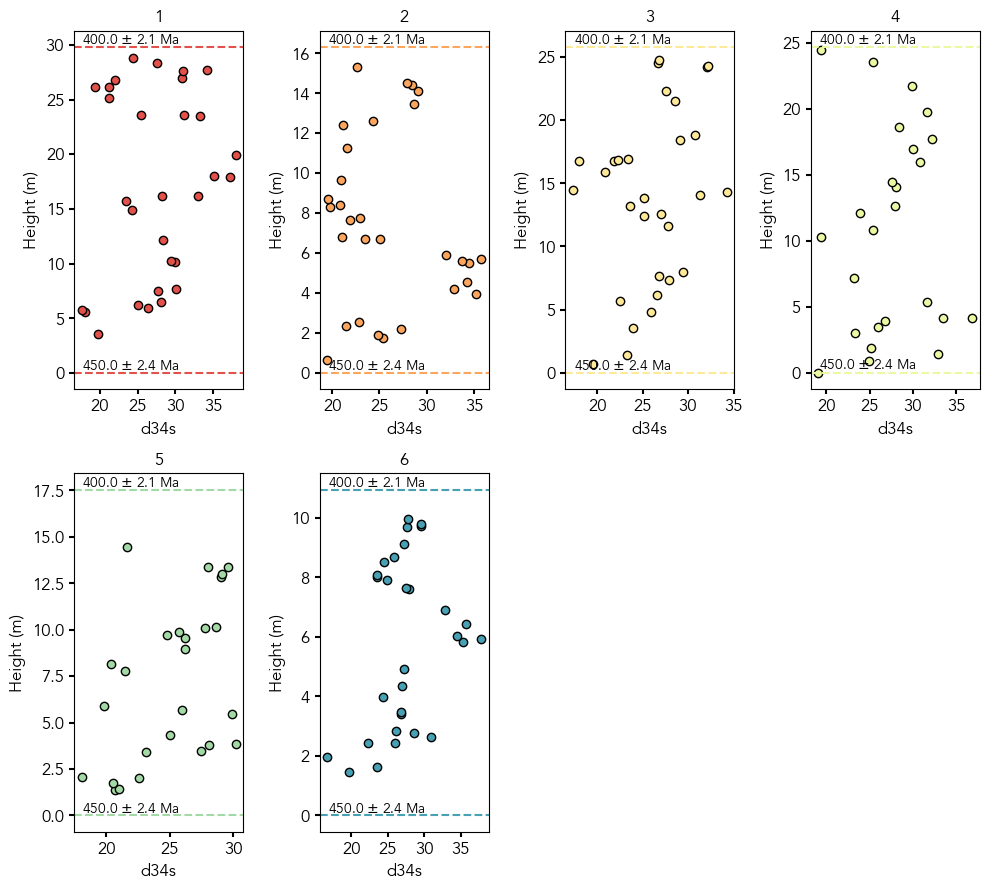

In [6]:
# Plot observations with stratmc.plotting.proxy_strat

for proxy in proxies:
    fig = stratmc.plotting.proxy_strat(sample_df, ages_df, proxy = proxy)

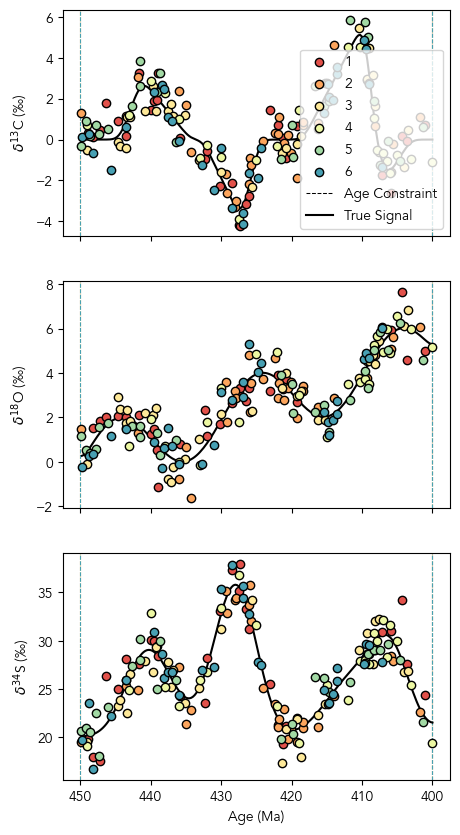

In [7]:
# plot proxy observations on top of synthetic signals
fig, ax = plt.subplots(3, 1, figsize = (5, 10), sharex = True)
cs = {}
pal = sns.color_palette('Spectral', n_colors = len(sections))
for i in np.arange(len(sections)):
    cs[sections[i]] = pal[i]

# d13c
for section in sections:
    ax[0].scatter(sample_df[sample_df['section']==section]['age'], 
                sample_df[sample_df['section']==section]['d13c'], 
                color = cs[section], 
                edgecolor = 'k',
                label = section)
    for age in ages_df[ages_df['section']==section]['age']:
        ax[0].axvline(age, color = cs[section], linestyle = 'dashed', zorder = -2, lw = 0.75)

ax[0].axvline(age, linestyle = 'dashed', color = 'k', lw = 0.75, zorder = -10, label = 'Age Constraint')
ax[0].plot(age_vector, d13c_signal, color = 'k', label = 'True Signal', zorder = -1)

# d18o
for section in sections:
    ax[1].scatter(sample_df[sample_df['section']==section]['age'], 
                sample_df[sample_df['section']==section]['d18o'], 
                color = cs[section], 
                edgecolor = 'k',
                label = section)
    if not all(np.isnan(sample_df[sample_df['section']==section]['d18o'])):
        for age in ages_df[ages_df['section']==section]['age']:
            ax[1].axvline(age, color = cs[section], linestyle = 'dashed', zorder = -2, lw = 0.75)

ax[1].axvline(age, linestyle = 'dashed', color = 'k', lw = 0.75, zorder = -10, label = 'Age Constraint')
ax[1].plot(age_vector, d18o_signal, color = 'k', label = 'True Signal', zorder = -1)

# d34s
for section in sections:
    ax[2].scatter(sample_df[sample_df['section']==section]['age'], 
                sample_df[sample_df['section']==section]['d34s'], 
                color = cs[section], 
                edgecolor = 'k',
                label = section)
    if not all(np.isnan(sample_df[sample_df['section']==section]['d34s'])):
        for age in ages_df[ages_df['section']==section]['age']:
            ax[2].axvline(age, color = cs[section], linestyle = 'dashed', zorder = -2, lw = 0.75)

ax[2].axvline(age, linestyle = 'dashed', color = 'k', lw = 0.75, zorder = -10, label = 'Age Constraint')
ax[2].plot(age_vector, d34s_signal, color = 'k', label = 'True Signal', zorder = -1)

ax[0].legend(loc = 'lower right')
ax[2].set_xlabel('Age (Ma)')
ax[0].set_ylabel('$\delta^{13}$C (‰)')
ax[1].set_ylabel('$\delta^{18}$O (‰)')
ax[2].set_ylabel('$\delta^{34}$S (‰)')

ax[0].invert_xaxis()

## Build the inference model and sample the posterior
For each experiment, modify the list of proxies passed to `build_model` and `get_trace`. To load the results for the inferences used to produce Fig. 8, skip to [Load the inference results](#Load-the-inference-results). 

In [ ]:
model, gp = stratmc.model.build_model(
                        sample_df, 
                        ages_df, 
                        proxies = ['d13c', 'd18o', 'd34s'], # change list of proxies to include different permutations of the data
                        ls_dist = 'Wald',
                        ls_min = 3, # minimum RBF kernel lengthscale
                        ls_mu = 10, # mean of Wald distribution used as RBF kernel lengthscale prior
                        ls_lambda = 25, # lambda of Wald distribution used as RBF kernel lengthscale prior
                        offset_type = 'section', # per-section offset with default prior
                        noise_type = 'section', # per-section noise with default prior
                        )

In [ ]:
# vector of ages at which to evaluate the proxy sigal
age_min = 400
age_max = 450

predict_ages = np.arange(age_min, age_max + 0.5, 0.5)[:,None]

extension = 'Fig8_synthetic_single_proxy_d13c_d18o_d34s' # modify name to reflect included proxies

full_trace = stratmc.inference.get_trace(model, 
                       gp, 
                       predict_ages,
                       sample_df, 
                       ages_df,
                       proxies = ['d13c', 'd18o', 'd34s'], 
                       name = extension, 
                       chains = 100, 
                       target_accept = 0.9
                      ) 


## Load the inference results
Load traces from experiments evaluated in Fig. 8 

In [8]:
# single proxy experiments
full_trace_d13C = stratmc.data.load_trace('traces/' + 'Fig8_multiproxy_d13c')
full_trace_d18O = stratmc.data.load_trace('traces/' + 'Fig8_multiproxy_d18o')
full_trace_d34S = stratmc.data.load_trace('traces/' + 'Fig8_multiproxy_d34s')

# two proxy experiments
full_trace_d13C_d18O = stratmc.data.load_trace('traces/' + 'Fig8_multiproxy_d13c_d18o')
full_trace_d13C_d34S = stratmc.data.load_trace('traces/' + 'Fig8_multiproxy_d13c_d34s')
full_trace_d18O_d34S = stratmc.data.load_trace('traces/' + 'Fig8_multiproxy_d18o_d34s')

# three proxy experiment
full_trace_all = stratmc.data.load_trace('traces/' + 'Fig8_multiproxy_all')

/Users/staceyedmonsond/opt/anaconda3/envs/bayestrat-dev-m1-pymc516-accelerate/lib/python3.11/site-packages/arviz/data/inference_data.py:157: UserWarning: X_new group is not defined in the InferenceData scheme
  warnings.warn(


## Quantify signal recovery 
Calculate the relative likelihood of each model (i.e., which models more accurately recover the synthetic proxy signals)

In [9]:
ages_new = full_trace_d13C.X_new.X_new.values

## interpolate signals to same vector of ages where the posterior proxy signal was evaluated
d13c_signal_interp = np.interp(ages_new, age_vector, d13c_signal)
d18o_signal_interp = np.interp(ages_new, age_vector, d18o_signal)
d34s_signal_interp = np.interp(ages_new, age_vector, d34s_signal)

# d13C signal recovery for each experiment
d13C_signal_recovery_single_proxy = stratmc.synthetics.quantify_signal_recovery(full_trace_d13C, d13c_signal_interp, proxy = 'd13c')
d13C_signal_recovery_two_proxies = stratmc.synthetics.quantify_signal_recovery([full_trace_d13C_d18O, full_trace_d13C_d34S], d13c_signal_interp, proxy = 'd13c')
d13C_signal_recovery_three_proxies = stratmc.synthetics.quantify_signal_recovery(full_trace_all, d13c_signal_interp, proxy = 'd13c')

# relative likelihood (compared to all models that include d13C)
d13C_ratio_vec_single_proxy = np.array(d13C_signal_recovery_single_proxy)/(np.array(d13C_signal_recovery_single_proxy) + np.array(d13C_signal_recovery_two_proxies) + np.array(d13C_signal_recovery_three_proxies))
d13C_ratio_vec_two_proxies = np.array(d13C_signal_recovery_two_proxies)/(np.array(d13C_signal_recovery_single_proxy) + np.array(d13C_signal_recovery_two_proxies) + np.array(d13C_signal_recovery_three_proxies))
d13C_ratio_vec_three_proxies = np.array(d13C_signal_recovery_three_proxies)/(np.array(d13C_signal_recovery_single_proxy) + np.array(d13C_signal_recovery_two_proxies) + np.array(d13C_signal_recovery_three_proxies))

# average relative likelihood
d13C_probs_ratio_single_proxy  = np.mean(d13C_ratio_vec_single_proxy) 
d13C_probs_ratio_two_proxies  = np.mean(d13C_ratio_vec_two_proxies)
d13C_probs_ratio_three_proxies  = np.mean(d13C_ratio_vec_three_proxies)

d13C_probs = [d13C_probs_ratio_single_proxy, d13C_probs_ratio_two_proxies, d13C_probs_ratio_three_proxies]

## d18O signal recovery for each experiment
d18O_signal_recovery_single_proxy = stratmc.synthetics.quantify_signal_recovery(full_trace_d18O, d18o_signal_interp, proxy = 'd18o')
d18O_signal_recovery_two_proxies = stratmc.synthetics.quantify_signal_recovery([full_trace_d13C_d18O, full_trace_d18O_d34S], d18o_signal_interp, proxy = 'd18o')
d18O_signal_recovery_three_proxies = stratmc.synthetics.quantify_signal_recovery(full_trace_all, d18o_signal_interp, proxy = 'd18o')

# relative likelihood (compared to all models that include d18O)
d18O_ratio_vec_single_proxy = np.array(d18O_signal_recovery_single_proxy)/(np.array(d18O_signal_recovery_single_proxy) + np.array(d18O_signal_recovery_two_proxies) + np.array(d18O_signal_recovery_three_proxies))
d18O_ratio_vec_two_proxies = np.array(d18O_signal_recovery_two_proxies)/(np.array(d18O_signal_recovery_single_proxy) + np.array(d18O_signal_recovery_two_proxies) + np.array(d18O_signal_recovery_three_proxies))
d18O_ratio_vec_three_proxies = np.array(d18O_signal_recovery_three_proxies)/(np.array(d18O_signal_recovery_single_proxy) + np.array(d18O_signal_recovery_two_proxies) + np.array(d18O_signal_recovery_three_proxies))

# average relative likelihood
d18O_probs_ratio_single_proxy  = np.mean(d18O_ratio_vec_single_proxy) 
d18O_probs_ratio_two_proxies  = np.mean(d18O_ratio_vec_two_proxies)
d18O_probs_ratio_three_proxies  = np.mean(d18O_ratio_vec_three_proxies)

d18O_probs = [d18O_probs_ratio_single_proxy, d18O_probs_ratio_two_proxies, d18O_probs_ratio_three_proxies]

## d34S signal recovery for each experiment
d34S_signal_recovery_single_proxy = stratmc.synthetics.quantify_signal_recovery(full_trace_d34S, d34s_signal_interp, proxy = 'd34s')

d34S_signal_recovery_two_proxies = stratmc.synthetics.quantify_signal_recovery([full_trace_d18O_d34S, full_trace_d13C_d34S], d34s_signal_interp, proxy = 'd34s')
d34S_signal_recovery_three_proxies = stratmc.synthetics.quantify_signal_recovery(full_trace_all, d34s_signal_interp, proxy = 'd34s')

# relative likelihood (compared to all models that include d34S)
d34S_ratio_vec_single_proxy = np.array(d34S_signal_recovery_single_proxy)/(np.array(d34S_signal_recovery_single_proxy) + np.array(d34S_signal_recovery_two_proxies) + np.array(d34S_signal_recovery_three_proxies))
d34S_ratio_vec_two_proxies = np.array(d34S_signal_recovery_two_proxies)/(np.array(d34S_signal_recovery_single_proxy) + np.array(d34S_signal_recovery_two_proxies) + np.array(d34S_signal_recovery_three_proxies))
d34S_ratio_vec_three_proxies = np.array(d34S_signal_recovery_three_proxies)/(np.array(d34S_signal_recovery_single_proxy) + np.array(d34S_signal_recovery_two_proxies) + np.array(d34S_signal_recovery_three_proxies))

# average relative likelihood
d34S_probs_ratio_single_proxy  = np.mean(d34S_ratio_vec_single_proxy) 
d34S_probs_ratio_two_proxies  = np.mean(d34S_ratio_vec_two_proxies)
d34S_probs_ratio_three_proxies  = np.mean(d34S_ratio_vec_three_proxies)

d34S_probs = [d34S_probs_ratio_single_proxy, d34S_probs_ratio_two_proxies, d34S_probs_ratio_three_proxies]

## Fig. 8c-d: d34S inferences and relative model likelihoods

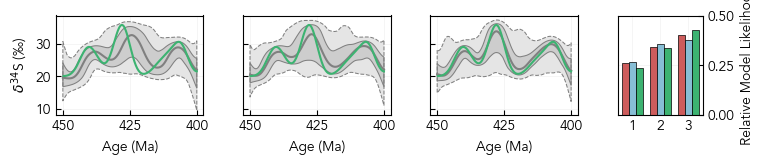

In [10]:
mosaic = """
        aaabbbcccdd
        """

fs = 10
fig, ax = plt.subplot_mosaic(mosaic,  figsize = (7.75, 1.75), sharex = False, sharey = False, constrained_layout = False)


_ = [ax[i].sharex(ax['a']) for i in 'bc']

_ = [ax[i].sharey(ax['a']) for i in 'bc']


#1  d34S only 
ages = full_trace_d34S.X_new.X_new.values
proxy_pred = az.extract(full_trace_d34S.posterior_predictive)['f_pred_' + 'd34s'].values

hi = np.percentile(proxy_pred, 97.5, axis=1).flatten()

lo = np.percentile(proxy_pred, 2.5, axis=1).flatten()

ax['a'].fill_between(ages.ravel(),
                        hi,
                        lo,
                        color= "white",
                        linestyle = '--', 
                        edgecolor = "none", 
                        alpha = 1,
                        lw = 0,  # 1.5
                        zorder = 1)

ax['a'].fill_between(ages.ravel(),
                         hi,
                        lo,
                        color = 'black',
                        linestyle = '--', 
                        edgecolor = "none", 
                        alpha = 0.1,
                        lw = 0,  # 1.5
                        zorder = 2)

ax['a'].fill_between(ages.ravel(),
                         hi,
                        lo,
                        color= "none",
                        label='95% envelope',  
                        linestyle = '--', 
                        edgecolor = 'gray',
                        alpha = 1,
                        lw = 0.75,  # 1.5
                        zorder = 3)

hi = np.percentile(proxy_pred, 100-16, axis=1).flatten()

lo = np.percentile(proxy_pred, 16, axis=1).flatten()

ax['a'].fill_between(ages.ravel(),
                        hi,
                        lo,
                        color = 'black',
                        edgecolor = "none",
                        alpha = 0.1, 
                        lw = 0, # 1.5
                        zorder = 4)

ax['a'].fill_between(ages.ravel(),
                        hi,
                        lo,
                        color="none",
                        label='68% envelope',
                        edgecolor = 'gray',
                        alpha = 1, 
                        lw = 0.75, # 1.5
                        zorder = 5)

dy = np.linspace(np.min(proxy_pred), np.max(proxy_pred), 200)
max_like = np.zeros(ages.size)
for i in np.arange(ages.size):
    time_slice = proxy_pred[i, :]
    max_like[i] = dy[np.argmax(gaussian_kde(time_slice, bw_method = 1)(dy))]


max_like = gaussian(max_like, 2)
ax['a'].plot(ages.ravel(),max_like, color = 'gray', linestyle = 'solid', lw = 1.5, zorder = 6, label = 'Most likely $\delta^{34}$S')

ax['a'].plot(age_vector, d34s_signal, color = 'mediumseagreen', label = 'True Signal', zorder = 10)


# 2. d34S posterior - two proxies
ages = full_trace_d13C_d34S.X_new.X_new.values
proxy_pred_1 = az.extract(full_trace_d13C_d34S.posterior_predictive)['f_pred_' + 'd34s'].values
proxy_pred_2 = az.extract(full_trace_d18O_d34S.posterior_predictive)['f_pred_' + 'd34s'].values
proxy_pred = np.hstack([proxy_pred_1, proxy_pred_2])

hi = np.percentile(proxy_pred, 97.5, axis=1).flatten()

lo = np.percentile(proxy_pred, 2.5, axis=1).flatten()

ax['b'].fill_between(ages.ravel(),
                        hi,
                        lo,
                        color= "white",
                        linestyle = '--', 
                        edgecolor = "none", 
                        alpha = 1,
                        lw = 0,  # 1.5
                        zorder = 1)

ax['b'].fill_between(ages.ravel(),
                         hi,
                        lo,
                        color = 'black',
                        linestyle = '--', 
                        edgecolor = "none", 
                        alpha = 0.1,
                        lw = 0,  # 1.5
                        zorder = 2)

ax['b'].fill_between(ages.ravel(),
                         hi,
                        lo,
                        color= "none",
                        label='95% envelope',  
                        linestyle = '--', 
                        edgecolor = 'gray',
                        alpha = 1,
                        lw = 0.75,  # 1.5
                        zorder = 3)

hi = np.percentile(proxy_pred, 100-16, axis=1).flatten()

lo = np.percentile(proxy_pred, 16, axis=1).flatten()

ax['b'].fill_between(ages.ravel(),
                        hi,
                        lo,
                        color = 'black',
                        edgecolor = "none",
                        alpha = 0.1, 
                        lw = 0, # 1.5
                        zorder = 4)

ax['b'].fill_between(ages.ravel(),
                        hi,
                        lo,
                        color="none",#(.8,.8,.8),
                        label='68% envelope',
                        edgecolor = 'gray',
                        alpha = 1, 
                        lw = 0.75, # 1.5
                        zorder = 5)

dy = np.linspace(np.min(proxy_pred), np.max(proxy_pred), 200)
max_like = np.zeros(ages.size)
for i in np.arange(ages.size):
    time_slice = proxy_pred[i, :]
    max_like[i] = dy[np.argmax(gaussian_kde(time_slice, bw_method = 1)(dy))]
    
max_like = gaussian(max_like, 2)
ax['b'].plot(ages.ravel(),max_like, color = 'gray', linestyle = 'solid', lw = 1.5, zorder = 6, label = 'Most likely $\delta^{34}$S')

ax['b'].plot(age_vector, d34s_signal, color = 'mediumseagreen', label = 'True Signal', zorder = 10)


# 3. d34S posterior - all 3 proxies inversion 
ages = full_trace_all.X_new.X_new.values
proxy_pred = az.extract(full_trace_all.posterior_predictive)['f_pred_' + 'd34s'].values

hi = np.percentile(proxy_pred, 97.5, axis=1).flatten()

lo = np.percentile(proxy_pred, 2.5, axis=1).flatten()

ax['c'].fill_between(ages.ravel(),
                        hi,
                        lo,
                        color= "white",
                        linestyle = '--', 
                        edgecolor = "none", 
                        alpha = 1,
                        lw = 0,  # 1.5
                        zorder = 1)

ax['c'].fill_between(ages.ravel(),
                         hi,
                        lo,
                        color = 'black',
                        linestyle = '--', 
                        edgecolor = "none", 
                        alpha = 0.1,
                        lw = 0,  # 1.5
                        zorder = 2)

ax['c'].fill_between(ages.ravel(),
                         hi,
                        lo,
                        color= "none",
                        label='95% envelope',  
                        linestyle = '--', 
                        edgecolor = 'gray',
                        alpha = 1,
                        lw = 0.75,  # 1.5
                        zorder = 3)

hi = np.percentile(proxy_pred, 100-16, axis=1).flatten()

lo = np.percentile(proxy_pred, 16, axis=1).flatten()

ax['c'].fill_between(ages.ravel(),
                        hi,
                        lo,
                        color = 'black',
                        #label='68% envelope',
                        edgecolor = "none",
                        alpha = 0.1, 
                        lw = 0, # 1.5
                        zorder = 4)

ax['c'].fill_between(ages.ravel(),
                        hi,
                        lo,
                        color="none",#(.8,.8,.8),
                        label='68% envelope',
                        edgecolor = 'gray',
                        alpha = 1, 
                        lw = 0.75, # 1.5
                        zorder = 5)

dy = np.linspace(np.min(proxy_pred), np.max(proxy_pred), 200)
max_like = np.zeros(ages.size)
for i in np.arange(ages.size):
    time_slice = proxy_pred[i, :]
    max_like[i] = dy[np.argmax(gaussian_kde(time_slice, bw_method = 1)(dy))]

max_like = gaussian(max_like, 2)
ax['c'].plot(ages.ravel(),max_like, color = 'gray', linestyle = 'solid', lw = 1.5, zorder = 6, label = 'Most likely $\delta^{34}$S')

ax['c'].plot(age_vector, d34s_signal, color = 'mediumseagreen', label = 'True Signal', zorder = 10)

for i in 'bc':
    [t.set_color('none') for t in ax[i].yaxis.get_ticklabels()]
    
for i in 'abcd':
    ax[i].set_axisbelow(True)
    ax[i].grid(color=(0.95, 0.95, 0.95), linewidth=0.5, linestyle = 'solid', zorder = -1)
    ax[i].tick_params(labelsize = fs) 
    
for i in 'abcd':
    ax[i].tick_params(direction = 'in', labelsize = fs) 
    
ax['d'].yaxis.tick_right()
ax['d'].yaxis.set_label_position('right') 
ax['d'].set_ylabel('Relative Model Likelihood', fontsize = fs) 

for i in 'abc':
    ax[i].set_xlabel('Age (Ma)', fontsize = fs) 
    
ax['a'].set_ylabel('$\delta^{34}$S (‰)', fontsize = fs)
    
ax['a'].invert_xaxis()

# signal recovery metrics
ax['d'].bar([0.75, 1.75, 2.75], d13C_probs, width = 0.25, color = 'indianred', alpha = 1, edgecolor = 'k', lw = 0.5)
ax['d'].bar([1, 2, 3], d18O_probs, width = 0.25, color = '#87BED5', alpha = 1, edgecolor = 'k', lw = 0.5)
ax['d'].bar([1.25, 2.25, 3.25], d34S_probs, width = 0.25, color = 'mediumseagreen', alpha = 1, edgecolor = 'k', lw = 0.5)

ax['d'].set_xticks(np.arange(1, 1 + len(d34S_probs)))
ax['d'].set_yticks([0, 0.25, 0.5])

ax['a'].set_xticks([450, 425, 400])
ax['a'].set_xlim([np.max(ages) + 2.5, np.min(ages) - 2.5])

fig.tight_layout()


## Grid with all inferences
Each column contains the proxy signal inferences for a different proxy (from left to right, d13C, d18O, and d34S). The proxy signal inference in each row correspond to models that include different numbers of proxies:
- Row 1: single proxy 
- Row 2: two proxies (combined posteriors for each permutation of the proxy data) 
- Row 3: all three proxies 

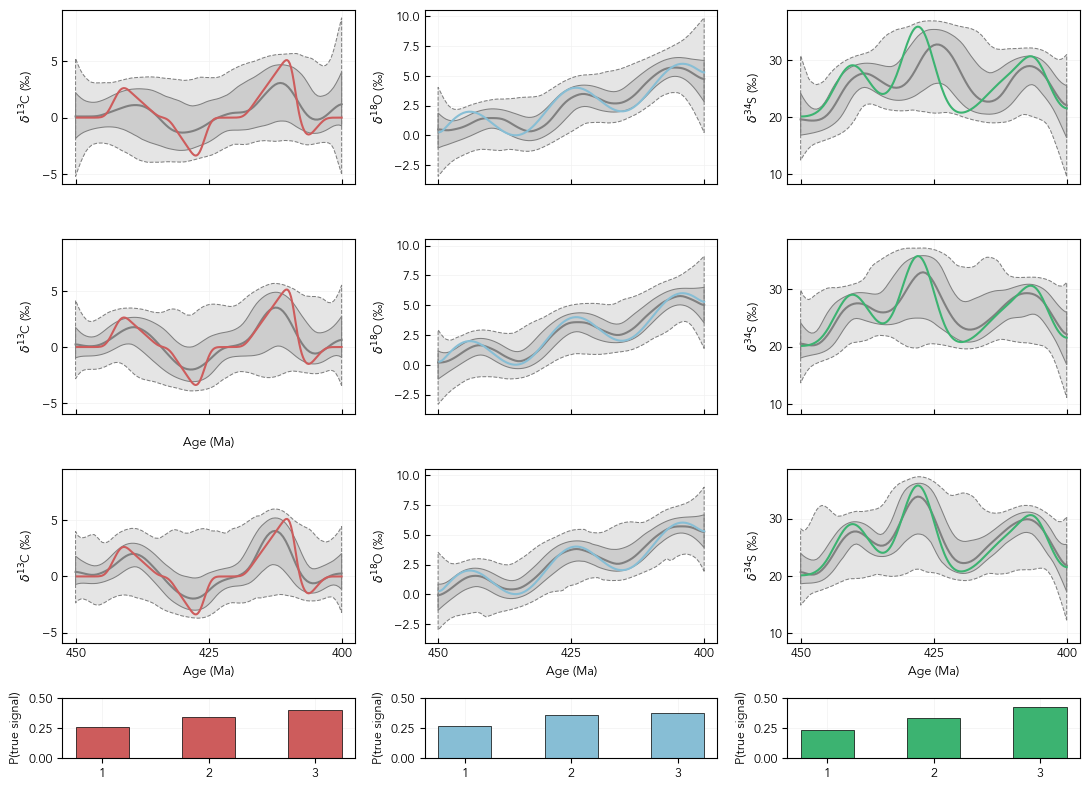

In [11]:

mosaic = """
    abc
    abc
    def
    def
    jkl
    jkl
    mno
    """

fs = 9
fig, ax = plt.subplot_mosaic(mosaic,  figsize = (11, 8), sharex = False, sharey = False, constrained_layout = False)


_ = [ax[i].sharex(ax['a']) for i in 'bcdefjkl']

_ = [ax[i].sharey(ax['a']) for i in 'dj']
_ = [ax[i].sharey(ax['b']) for i in 'ek']
_ = [ax[i].sharey(ax['c']) for i in 'fl']
_ = [ax[i].sharex(ax['m']) for i in 'no']
_ = [ax[i].sharey(ax['m']) for i in 'no']


# 1. d13C single proxy
ages = full_trace_d13C.X_new.X_new.values
proxy_pred = az.extract(full_trace_d13C.posterior_predictive)['f_pred_' + 'd13c'].values

hi = np.percentile(proxy_pred, 97.5, axis=1).flatten()

lo = np.percentile(proxy_pred, 2.5, axis=1).flatten()

ax['a'].fill_between(ages.ravel(),
                        hi,
                        lo,
                        color= "white",
                        #label='95% envelope',  
                        linestyle = '--', 
                        edgecolor = "none", 
                        alpha = 1,
                        lw = 0,  # 1.5
                        zorder = 1)

ax['a'].fill_between(ages.ravel(),
                         hi,
                        lo,
                        color = 'black',
                        #label='95% envelope',  
                        linestyle = '--', 
                        edgecolor = "none", 
                        alpha = 0.1,
                        lw = 0,  # 1.5
                        zorder = 2)

ax['a'].fill_between(ages.ravel(),
                         hi,
                        lo,
                        color= "none", #(.95,.95,.95),
                        label='95% envelope',  
                        linestyle = '--', 
                        edgecolor = 'gray', 
                        alpha = 1,
                        lw = 0.75,  # 1.5
                        zorder = 3)

hi = np.percentile(proxy_pred, 100-16, axis=1).flatten()

lo = np.percentile(proxy_pred, 16, axis=1).flatten()

ax['a'].fill_between(ages.ravel(),
                        hi,
                        lo,
                        color = 'black',
                        #label='68% envelope',
                        edgecolor = "none",
                        alpha = 0.1, 
                        lw = 0, # 1.5
                        zorder = 4)

ax['a'].fill_between(ages.ravel(),
                        hi,
                        lo,
                        color="none",#(.8,.8,.8),
                        label='68% envelope',
                        edgecolor = 'gray',
                        alpha = 1, 
                        lw = 0.75, # 1.5
                        zorder = 5)

dy = np.linspace(np.min(proxy_pred), np.max(proxy_pred), 200)
max_like = np.zeros(ages.size)
for i in np.arange(ages.size):
    time_slice = proxy_pred[i, :]
    max_like[i] = dy[np.argmax(gaussian_kde(time_slice, bw_method = 1)(dy))]

max_like = gaussian(max_like, 2)
ax['a'].plot(ages.ravel(),max_like, color = 'gray', linestyle = 'solid', lw = 1.5, zorder = 6, label = 'Most likely $\delta^{13}$C')

ax['a'].plot(age_vector, d13c_signal, color = 'indianred', label = 'True Signal', zorder = 10)

ax['a'].set_xlim([np.max(ages) + 2.5, np.min(ages) - 2.5])

# 2. d13C posterior - two proxies
ages = full_trace_d13C_d18O.X_new.X_new.values
proxy_pred_1 = az.extract(full_trace_d13C_d18O.posterior_predictive)['f_pred_' + 'd13c'].values
proxy_pred_2 = az.extract(full_trace_d13C_d34S.posterior_predictive)['f_pred_' + 'd13c'].values
proxy_pred = np.hstack([proxy_pred_1, proxy_pred_2])

hi = np.percentile(proxy_pred, 97.5, axis=1).flatten()

lo = np.percentile(proxy_pred, 2.5, axis=1).flatten()

ax['d'].fill_between(ages.ravel(),
                        hi,
                        lo,
                        color= "white",
                        #label='95% envelope',  
                        linestyle = '--', 
                        edgecolor = "none", 
                        alpha = 1,
                        lw = 0,  # 1.5
                        zorder = 1)

ax['d'].fill_between(ages.ravel(),
                         hi,
                        lo,
                        color = 'black', #"#e74c3c", #(.95,.95,.95),
                        linestyle = '--', 
                        edgecolor = "none", 
                        alpha = 0.1,
                        lw = 0,  # 1.5
                        zorder = 2)

ax['d'].fill_between(ages.ravel(),
                         hi,
                        lo,
                        color= "none", #(.95,.95,.95),
                        label='95% envelope',  
                        linestyle = '--', 
                        edgecolor = 'gray', 
                        alpha = 1,
                        lw = 0.75,  # 1.5
                        zorder = 3)

hi = np.percentile(proxy_pred, 100-16, axis=1).flatten()

lo = np.percentile(proxy_pred, 16, axis=1).flatten()

ax['d'].fill_between(ages.ravel(),
                        hi,
                        lo,
                        color = 'black',
                        edgecolor = "none",
                        alpha = 0.1, 
                        lw = 0,
                        zorder = 4)

ax['d'].fill_between(ages.ravel(),
                        hi,
                        lo,
                        color="none",#(.8,.8,.8),
                        label='68% envelope',
                        edgecolor = 'gray',
                        alpha = 1, 
                        lw = 0.75, # 1.5
                        zorder = 5)

dy = np.linspace(np.min(proxy_pred), np.max(proxy_pred), 200)
max_like = np.zeros(ages.size)
for i in np.arange(ages.size):
    time_slice = proxy_pred[i, :]
    max_like[i] = dy[np.argmax(gaussian_kde(time_slice, bw_method = 1)(dy))]

max_like = gaussian(max_like, 2)
ax['d'].plot(ages.ravel(),max_like, color = 'gray', linestyle = 'solid', lw = 1.5, zorder = 6, label = 'Most likely $\delta^{13}$C')

ax['d'].plot(age_vector, d13c_signal, color = 'indianred', label = 'True Signal', zorder = 10)

ax['d'].set_xlabel('Age (Ma)', fontsize = fs)


# 4. d13C posterior - all 3 proxies inversion 

ages = full_trace_all.X_new.X_new.values
proxy_pred = az.extract(full_trace_all.posterior_predictive)['f_pred_' + 'd13c'].values

hi = np.percentile(proxy_pred, 97.5, axis=1).flatten()

lo = np.percentile(proxy_pred, 2.5, axis=1).flatten()

ax['j'].fill_between(ages.ravel(),
                        hi,
                        lo,
                        color= "white",
                        #label='95% envelope',  
                        linestyle = '--', 
                        edgecolor = "none", 
                        alpha = 1,
                        lw = 0,  # 1.5
                        zorder = 1)

ax['j'].fill_between(ages.ravel(),
                         hi,
                        lo,
                        color = 'black', 
                        linestyle = '--', 
                        edgecolor = "none", 
                        alpha = 0.1,
                        lw = 0,  # 1.5
                        zorder = 2)

ax['j'].fill_between(ages.ravel(),
                         hi,
                        lo,
                        color= "none", #(.95,.95,.95),
                        label='95% envelope',  
                        linestyle = '--', 
                        edgecolor = 'gray',
                        alpha = 1,
                        lw = 0.75,  # 1.5
                        zorder = 3)

hi = np.percentile(proxy_pred, 100-16, axis=1).flatten()

lo = np.percentile(proxy_pred, 16, axis=1).flatten()

ax['j'].fill_between(ages.ravel(),
                        hi,
                        lo,
                        color = 'black',
                        edgecolor = "none",
                        alpha = 0.1, 
                        lw = 0,
                        zorder = 4)

ax['j'].fill_between(ages.ravel(),
                        hi,
                        lo,
                        color="none",#(.8,.8,.8),
                        label='68% envelope',
                        edgecolor = 'gray',
                        alpha = 1, 
                        lw = 0.75, # 1.5
                        zorder = 5)

dy = np.linspace(np.min(proxy_pred), np.max(proxy_pred), 200)
max_like = np.zeros(ages.size)
for i in np.arange(ages.size):
    time_slice = proxy_pred[i, :]
    max_like[i] = dy[np.argmax(gaussian_kde(time_slice, bw_method = 1)(dy))]

max_like = gaussian(max_like, 2)
ax['j'].plot(ages.ravel(),max_like, color = 'gray', linestyle = 'solid', lw = 1.5, zorder = 6, label = 'Most likely $\delta^{13}$C')

ax['j'].plot(age_vector, d13c_signal, color = 'indianred', label = 'True Signal', zorder = 10)

# 4. d18O posterior - d18O only inversion
ages = full_trace_d18O.X_new.X_new.values
proxy_pred = az.extract(full_trace_d18O.posterior_predictive)['f_pred_' + 'd18o'].values

hi = np.percentile(proxy_pred, 97.5, axis=1).flatten()

lo = np.percentile(proxy_pred, 2.5, axis=1).flatten()

ax['b'].fill_between(ages.ravel(),
                        hi,
                        lo,
                        color= "white",
                        linestyle = '--', 
                        edgecolor = "none", 
                        alpha = 1,
                        lw = 0,  # 1.5
                        zorder = 1)

ax['b'].fill_between(ages.ravel(),
                         hi,
                        lo,
                        color = 'black',
                        linestyle = '--', 
                        edgecolor = "none", 
                        alpha = 0.1,
                        lw = 0,  # 1.5
                        zorder = 2)

ax['b'].fill_between(ages.ravel(),
                         hi,
                        lo,
                        color= "none", #(.95,.95,.95),
                        label='95% envelope',  
                        linestyle = '--', 
                        edgecolor = 'gray',
                        alpha = 1,
                        lw = 0.75,  # 1.5
                        zorder = 3)

hi = np.percentile(proxy_pred, 100-16, axis=1).flatten()

lo = np.percentile(proxy_pred, 16, axis=1).flatten()

ax['b'].fill_between(ages.ravel(),
                        hi,
                        lo,
                        color = 'black',
                        #label='68% envelope',
                        edgecolor = "none",
                        alpha = 0.1, 
                        lw = 0, # 1.5
                        zorder = 4)

ax['b'].fill_between(ages.ravel(),
                        hi,
                        lo,
                        color="none",#(.8,.8,.8),
                        label='68% envelope',
                        edgecolor = 'gray',
                        alpha = 1, 
                        lw = 0.75, # 1.5
                        zorder = 5)

dy = np.linspace(np.min(proxy_pred), np.max(proxy_pred), 200)
max_like = np.zeros(ages.size)
for i in np.arange(ages.size):
    time_slice = proxy_pred[i, :]
    max_like[i] = dy[np.argmax(gaussian_kde(time_slice, bw_method = 1)(dy))]

max_like = gaussian(max_like, 2)
ax['b'].plot(ages.ravel(),max_like, color = 'gray', linestyle = 'solid', lw = 1.5, zorder = 6, label = 'Most likely $\delta^{18}$O')

ax['b'].plot(age_vector, d18o_signal, color = '#87BED5', label = 'True Signal', zorder = 10)

# 5. d18O posterior - two proxies
ages = full_trace_d13C_d18O.X_new.X_new.values
proxy_pred_1 = az.extract(full_trace_d13C_d18O.posterior_predictive)['f_pred_' + 'd18o'].values
proxy_pred_2 = az.extract(full_trace_d18O_d34S.posterior_predictive)['f_pred_' + 'd18o'].values
proxy_pred = np.hstack([proxy_pred_1, proxy_pred_2])

hi = np.percentile(proxy_pred, 97.5, axis=1).flatten()

lo = np.percentile(proxy_pred, 2.5, axis=1).flatten()

ax['e'].fill_between(ages.ravel(),
                        hi,
                        lo,
                        color= "white",
                        linestyle = '--', 
                        edgecolor = "none", 
                        alpha = 1,
                        lw = 0,  # 1.5
                        zorder = 1)

ax['e'].fill_between(ages.ravel(),
                         hi,
                        lo,
                        color = 'black',
                        linestyle = '--', 
                        edgecolor = "none", 
                        alpha = 0.1,
                        lw = 0,  # 1.5
                        zorder = 2)

ax['e'].fill_between(ages.ravel(),
                         hi,
                        lo,
                        color= "none", #(.95,.95,.95),
                        label='95% envelope',  
                        linestyle = '--', 
                        edgecolor = 'gray',
                        alpha = 1,
                        lw = 0.75,  # 1.5
                        zorder = 3)

hi = np.percentile(proxy_pred, 100-16, axis=1).flatten()

lo = np.percentile(proxy_pred, 16, axis=1).flatten()

ax['e'].fill_between(ages.ravel(),
                        hi,
                        lo,
                        color = 'black',
                        #label='68% envelope',
                        edgecolor = "none",
                        alpha = 0.1, 
                        lw = 0, # 1.5
                        zorder = 4)

ax['e'].fill_between(ages.ravel(),
                        hi,
                        lo,
                        color="none",#(.8,.8,.8),
                        label='68% envelope',
                        edgecolor = 'gray',
                        alpha = 1, 
                        lw = 0.75, # 1.5
                        zorder = 5)

dy = np.linspace(np.min(proxy_pred), np.max(proxy_pred), 200)
max_like = np.zeros(ages.size)
for i in np.arange(ages.size):
    time_slice = proxy_pred[i, :]
    max_like[i] = dy[np.argmax(gaussian_kde(time_slice, bw_method = 1)(dy))]

max_like = gaussian(max_like, 2)
ax['e'].plot(ages.ravel(),max_like, color = 'gray', linestyle = 'solid', lw = 1.5, zorder = 6, label = 'Most likely $\delta^{18}$O')

ax['e'].plot(age_vector, d18o_signal, color = '#87BED5', label = 'True Signal', zorder = 10)

ax['e'].invert_xaxis()
ax['e'].set_xlim([np.max(ages) + 2.5, np.min(ages) - 2.5])

ax['e'].set_ylabel('$\delta^{18}$O (‰)', fontsize = fs)

# 6. d18O posterior - all 3 proxies inversion 
ages = full_trace_all.X_new.X_new.values
proxy_pred = az.extract(full_trace_all.posterior_predictive)['f_pred_' + 'd18o'].values

hi = np.percentile(proxy_pred, 97.5, axis=1).flatten()

lo = np.percentile(proxy_pred, 2.5, axis=1).flatten()

ax['k'].fill_between(ages.ravel(),
                        hi,
                        lo,
                        color= "white",
                        linestyle = '--', 
                        edgecolor = "none", 
                        alpha = 1,
                        lw = 0,  # 1.5
                        zorder = 1)

ax['k'].fill_between(ages.ravel(),
                         hi,
                        lo,
                        color = 'black',
                        linestyle = '--', 
                        edgecolor = "none", 
                        alpha = 0.1,
                        lw = 0,  # 1.5
                        zorder = 2)

ax['k'].fill_between(ages.ravel(),
                         hi,
                        lo,
                        color= "none", #(.95,.95,.95),
                        label='95% envelope',  
                        linestyle = '--', 
                        edgecolor = 'gray',
                        alpha = 1,
                        lw = 0.75,  # 1.5
                        zorder = 3)

hi = np.percentile(proxy_pred, 100-16, axis=1).flatten()

lo = np.percentile(proxy_pred, 16, axis=1).flatten()

ax['k'].fill_between(ages.ravel(),
                        hi,
                        lo,
                        color = 'black',
                        #label='68% envelope',
                        edgecolor = "none",
                        alpha = 0.1, 
                        lw = 0, # 1.5
                        zorder = 4)

ax['k'].fill_between(ages.ravel(),
                        hi,
                        lo,
                        color="none",#(.8,.8,.8),
                        label='68% envelope',
                        edgecolor = 'gray',
                        alpha = 1, 
                        lw = 0.75, # 1.5
                        zorder = 5)

dy = np.linspace(np.min(proxy_pred), np.max(proxy_pred), 200)
max_like = np.zeros(ages.size)
for i in np.arange(ages.size):
    time_slice = proxy_pred[i, :]
    max_like[i] = dy[np.argmax(gaussian_kde(time_slice, bw_method = 1)(dy))]

max_like = gaussian(max_like, 2)
ax['k'].plot(ages.ravel(),max_like, color = 'gray', linestyle = 'solid', lw = 1.5, zorder = 6, label = 'Most likely $\delta^{18}$O')

ax['k'].plot(age_vector, d18o_signal, color = '#87BED5', label = 'True Signal', zorder = 10)

#7  d34S only 
ages = full_trace_d34S.X_new.X_new.values
proxy_pred = az.extract(full_trace_d34S.posterior_predictive)['f_pred_' + 'd34s'].values

hi = np.percentile(proxy_pred, 97.5, axis=1).flatten()

lo = np.percentile(proxy_pred, 2.5, axis=1).flatten()

ax['c'].fill_between(ages.ravel(),
                        hi,
                        lo,
                        color= "white",
                        linestyle = '--', 
                        edgecolor = "none", 
                        alpha = 1,
                        lw = 0,  # 1.5
                        zorder = 1)

ax['c'].fill_between(ages.ravel(),
                         hi,
                        lo,
                        color = 'black',
                        linestyle = '--', 
                        edgecolor = "none", 
                        alpha = 0.1,
                        lw = 0,  # 1.5
                        zorder = 2)

ax['c'].fill_between(ages.ravel(),
                         hi,
                        lo,
                        color= "none",
                        label='95% envelope',  
                        linestyle = '--', 
                        edgecolor = 'gray',
                        alpha = 1,
                        lw = 0.75,  # 1.5
                        zorder = 3)

hi = np.percentile(proxy_pred, 100-16, axis=1).flatten()

lo = np.percentile(proxy_pred, 16, axis=1).flatten()

ax['c'].fill_between(ages.ravel(),
                        hi,
                        lo,
                        color = 'black',
                        #label='68% envelope',
                        edgecolor = "none",
                        alpha = 0.1, 
                        lw = 0, # 1.5
                        zorder = 4)

ax['c'].fill_between(ages.ravel(),
                        hi,
                        lo,
                        color="none",#(.8,.8,.8),
                        label='68% envelope',
                        edgecolor = 'gray',
                        alpha = 1, 
                        lw = 0.75, # 1.5
                        zorder = 5)

dy = np.linspace(np.min(proxy_pred), np.max(proxy_pred), 200)
max_like = np.zeros(ages.size)
for i in np.arange(ages.size):
    time_slice = proxy_pred[i, :]
    max_like[i] = dy[np.argmax(gaussian_kde(time_slice, bw_method = 1)(dy))]

max_like = gaussian(max_like, 2)
ax['c'].plot(ages.ravel(),max_like, color = 'gray', linestyle = 'solid', lw = 1.5, zorder = 6, label = 'Most likely $\delta^{34}$S')

ax['c'].plot(age_vector, d34s_signal, color = 'mediumseagreen', label = 'True Signal', zorder = 10)


# 8. d34S posterior - two proxies
ages = full_trace_d13C_d34S.X_new.X_new.values
proxy_pred_1 = az.extract(full_trace_d13C_d34S.posterior_predictive)['f_pred_' + 'd34s'].values
proxy_pred_2 = az.extract(full_trace_d18O_d34S.posterior_predictive)['f_pred_' + 'd34s'].values
proxy_pred = np.hstack([proxy_pred_1, proxy_pred_2])

hi = np.percentile(proxy_pred, 97.5, axis=1).flatten()

lo = np.percentile(proxy_pred, 2.5, axis=1).flatten()

ax['f'].fill_between(ages.ravel(),
                        hi,
                        lo,
                        color= "white",
                        linestyle = '--', 
                        edgecolor = "none", 
                        alpha = 1,
                        lw = 0,  # 1.5
                        zorder = 1)

ax['f'].fill_between(ages.ravel(),
                         hi,
                        lo,
                        color = 'black',
                        linestyle = '--', 
                        edgecolor = "none", 
                        alpha = 0.1,
                        lw = 0,  # 1.5
                        zorder = 2)

ax['f'].fill_between(ages.ravel(),
                         hi,
                        lo,
                        color= "none",
                        label='95% envelope',  
                        linestyle = '--', 
                        edgecolor = 'gray',
                        alpha = 1,
                        lw = 0.75,  # 1.5
                        zorder = 3)

hi = np.percentile(proxy_pred, 100-16, axis=1).flatten()

lo = np.percentile(proxy_pred, 16, axis=1).flatten()

ax['f'].fill_between(ages.ravel(),
                        hi,
                        lo,
                        color = 'black',
                        #label='68% envelope',
                        edgecolor = "none",
                        alpha = 0.1, 
                        lw = 0, # 1.5
                        zorder = 4)

ax['f'].fill_between(ages.ravel(),
                        hi,
                        lo,
                        color="none",#(.8,.8,.8),
                        label='68% envelope',
                        edgecolor = 'gray',
                        alpha = 1, 
                        lw = 0.75, # 1.5
                        zorder = 5)

dy = np.linspace(np.min(proxy_pred), np.max(proxy_pred), 200)
max_like = np.zeros(ages.size)
for i in np.arange(ages.size):
    time_slice = proxy_pred[i, :]
    max_like[i] = dy[np.argmax(gaussian_kde(time_slice, bw_method = 1)(dy))]

max_like = gaussian(max_like, 2)
ax['f'].plot(ages.ravel(),max_like, color = 'gray', linestyle = 'solid', lw = 1.5, zorder = 6, label = 'Most likely $\delta^{34}$S')

ax['f'].plot(age_vector, d34s_signal, color = 'mediumseagreen', label = 'True Signal', zorder = 10)


# 12. d34S posterior - all 3 proxies inversion 
ages = full_trace_all.X_new.X_new.values
proxy_pred = az.extract(full_trace_all.posterior_predictive)['f_pred_' + 'd34s'].values

hi = np.percentile(proxy_pred, 97.5, axis=1).flatten()

lo = np.percentile(proxy_pred, 2.5, axis=1).flatten()

ax['l'].fill_between(ages.ravel(),
                        hi,
                        lo,
                        color= "white",
                        linestyle = '--', 
                        edgecolor = "none", 
                        alpha = 1,
                        lw = 0,  # 1.5
                        zorder = 1)

ax['l'].fill_between(ages.ravel(),
                         hi,
                        lo,
                        color = 'black',
                        linestyle = '--', 
                        edgecolor = "none", 
                        alpha = 0.1,
                        lw = 0,  # 1.5
                        zorder = 2)

ax['l'].fill_between(ages.ravel(),
                         hi,
                        lo,
                        color= "none",
                        label='95% envelope',  
                        linestyle = '--', 
                        edgecolor = 'gray',
                        alpha = 1,
                        lw = 0.75,  # 1.5
                        zorder = 3)

hi = np.percentile(proxy_pred, 100-16, axis=1).flatten()

lo = np.percentile(proxy_pred, 16, axis=1).flatten()

ax['l'].fill_between(ages.ravel(),
                        hi,
                        lo,
                        color = 'black',
                        #label='68% envelope',
                        edgecolor = "none",
                        alpha = 0.1, 
                        lw = 0, # 1.5
                        zorder = 4)

ax['l'].fill_between(ages.ravel(),
                        hi,
                        lo,
                        color="none",#(.8,.8,.8),
                        label='68% envelope',
                        edgecolor = 'gray',
                        alpha = 1, 
                        lw = 0.75, # 1.5
                        zorder = 5)

dy = np.linspace(np.min(proxy_pred), np.max(proxy_pred), 200)
max_like = np.zeros(ages.size)
for i in np.arange(ages.size):
    time_slice = proxy_pred[i, :]
    max_like[i] = dy[np.argmax(gaussian_kde(time_slice, bw_method = 1)(dy))]

max_like = gaussian(max_like, 2)
ax['l'].plot(ages.ravel(),max_like, color = 'gray', linestyle = 'solid', lw = 1.5, zorder = 6, label = 'Most likely $\delta^{34}$S')

ax['l'].plot(age_vector, d34s_signal, color = 'mediumseagreen', label = 'True Signal', zorder = 10)

# for i in 'no':
#     [t.set_color('none') for t in ax[i].yaxis.get_ticklabels()]
    
for i in 'abcdef':
    [t.set_color('none') for t in ax[i].xaxis.get_ticklabels()]
    
for i in 'abcdefjklmno':
    ax[i].set_axisbelow(True)
    ax[i].grid(color=(0.95, 0.95, 0.95), linewidth=0.5, linestyle = 'solid', zorder = -1)
    ax[i].tick_params(labelsize = fs) 
    
for i in 'abcdefjkl':
    ax[i].tick_params(direction = 'in', labelsize = fs) 
    
for i in 'mno':
    #ax[i].yaxis.tick_right()
    #ax[i].yaxis.set_label_position('right') 
    ax[i].set_ylabel('P(true signal)', fontsize = fs) 

for i in 'jkl':
    ax[i].set_xlabel('Age (Ma)', fontsize = fs) 
    
for i in 'cfl':
    ax[i].set_ylabel('$\delta^{34}$S (‰)', fontsize = fs)

for i in 'adj':
    ax[i].set_ylabel('$\delta^{13}$C (‰)', fontsize = fs)
    
for i in 'bek':
    ax[i].set_ylabel('$\delta^{18}$O (‰)', fontsize = fs)
    
ax['a'].invert_xaxis()

# signal recovery metrics
# d13C

ax['m'].bar(np.arange(1, 1 + len(d13C_probs)), d13C_probs, width = 0.5, color = 'indianred', alpha = 1, edgecolor = 'k', lw = 0.5)

ax['m'].set_xticks(np.arange(1, 1 + len(d13C_probs)))

# d18O

ax['n'].bar(np.arange(1, 1 + len(d18O_probs)), d18O_probs, width = 0.5, color = '#87BED5', alpha = 1, edgecolor = 'k', lw = 0.5)

ax['n'].set_xticks(np.arange(1, 1 + len(d18O_probs)))


ax['o'].bar(np.arange(1, 1 + len(d34S_probs)), d34S_probs, width = 0.5, color = 'mediumseagreen', alpha = 1, edgecolor = 'k', lw = 0.5)

ax['o'].set_xticks(np.arange(1, 1 + len(d34S_probs)))

ax['a'].set_xticks([450, 425, 400])
ax['a'].set_xlim([np.max(ages) + 2.5, np.min(ages) - 2.5])

for i in 'mno':
    ax[i].set_yticks([0, 0.25, 0.5])

fig.tight_layout()
